# The model : Learning place cells, grid cells and invariances with excitatory and inhibitory plasticity 

Simon Nikolaus Weber, Henning Sprekeler

https://elifesciences.org/articles/34560


$$r^{out}(x(t)) =[ \sum^{Ne}_{i=1} w_i^{E}(t)r_i^{E}(x(t))-\sum^{Ni}_{j=1} w_j^{I}(t)r_j^{I}(x(t)) ]$$

$$\delta w^{E}= \eta_E r^{E}(x)r^{out}(x)$$

$$r_i^P(x)=\alpha_p exp\big({-\frac{(x-\mu_i)^2}{2\sigma_p^2}}\big)$$


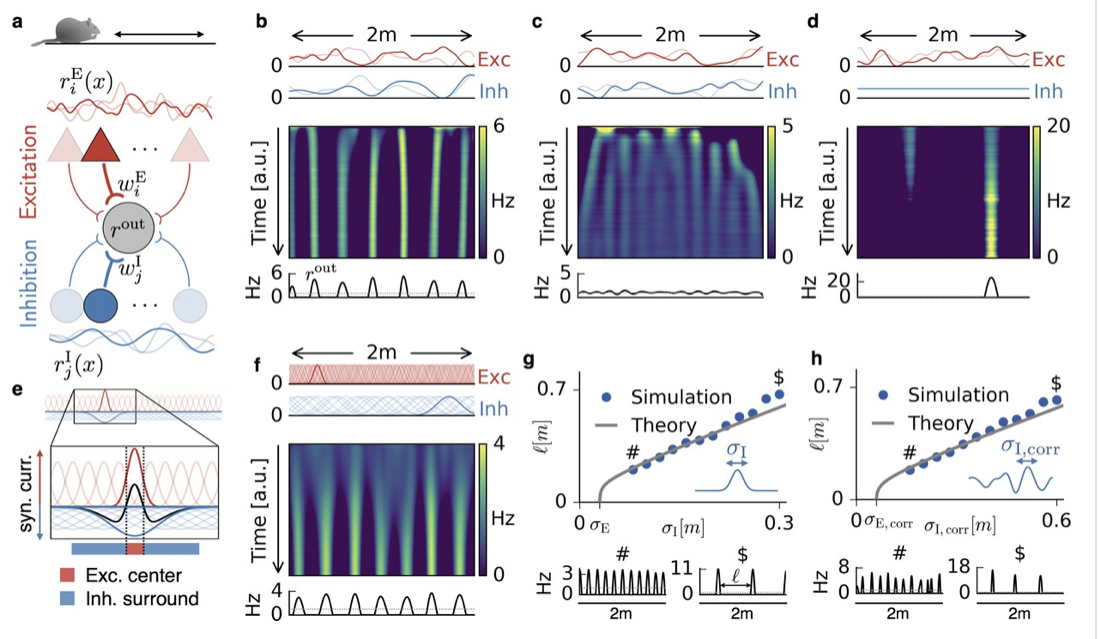

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from neuralplayground.arenas import Simple2D, Wernle2018, MergingRoom
from neuralplayground.agents import Weber2018, RandomAgent, LevyFlightAgent

In [2]:
room_width = [-10,10]
room_depth = [-10,10]
env_name = "env_example"
time_step_size = 1
agent_step_size = 0.5

# Init environment
envsimple = Simple2D(arena_x_limits = room_width,
                     arena_y_limits = room_depth,
                     time_step_size = time_step_size,
                     agent_step_size = agent_step_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4900/4900 [00:02<00:00, 2206.59it/s]


array([<AxesSubplot: title={'center': 'Exc rates'}>,
       <AxesSubplot: title={'center': 'Inh rates'}>,
       <AxesSubplot: title={'center': 'Out rate'}>], dtype=object)

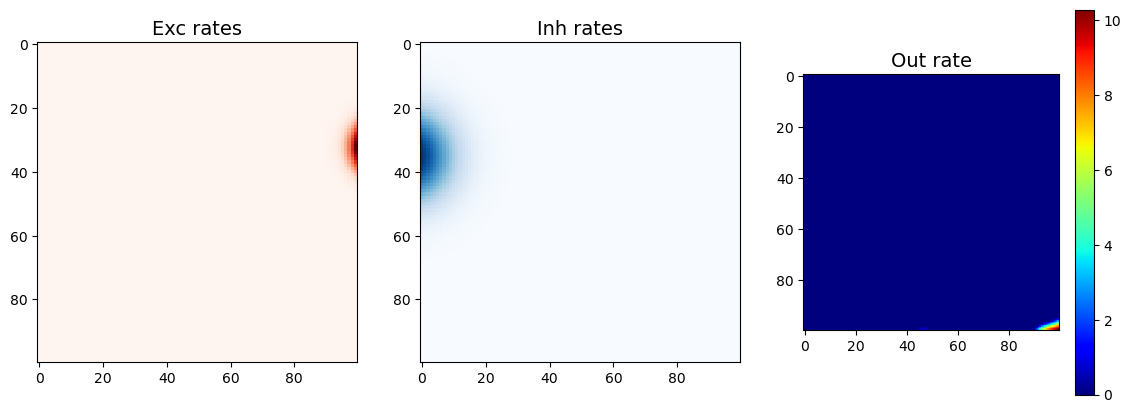

In [3]:
exc_eta = 2e-4
inh_eta = 8e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 4900
Ni = 1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.5
agent_step_size = 0.1
agent = Weber2018(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                  sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=1,
                  Nef=Nef, Nif=Nif, room_width=envsimple.room_width, room_depth=envsimple.room_depth,
                  alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)

agent.plot_rates()

  0%|                                                                                                                                                                         | 94/400000 [00:00<22:59, 289.92it/s]


KeyboardInterrupt: 

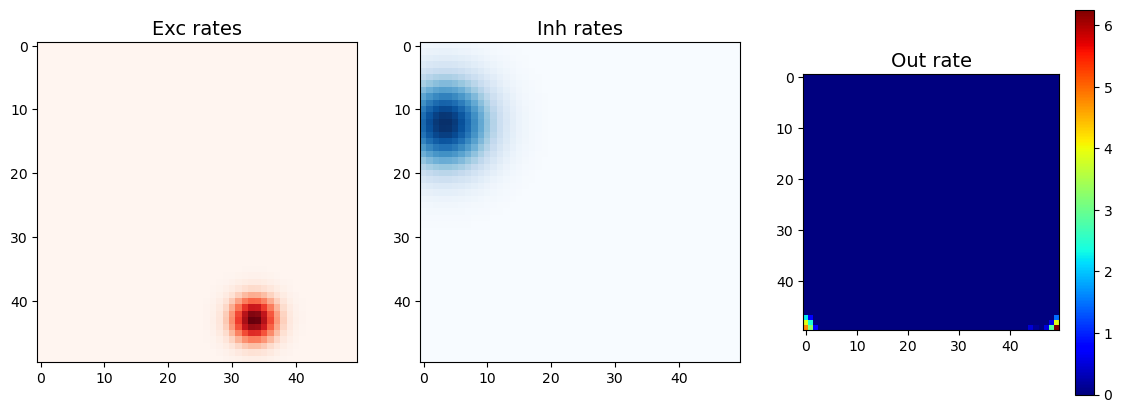

In [4]:
plot_every = 100000
total_iters = 0
n_steps = 400000
obs, state = envsimple.reset()
for i in tqdm(range(n_steps)):
    # Observe to choose an action 
    obs = obs[:2]
    action = agent.act(obs)
    # rate = agent.update()
    agent.update()
    # Run environment for given action
    obs, state, reward = envsimple.step(action, normalize_step=True)
    total_iters += 1
    if i % plot_every == 0:
        agent.plot_rates()

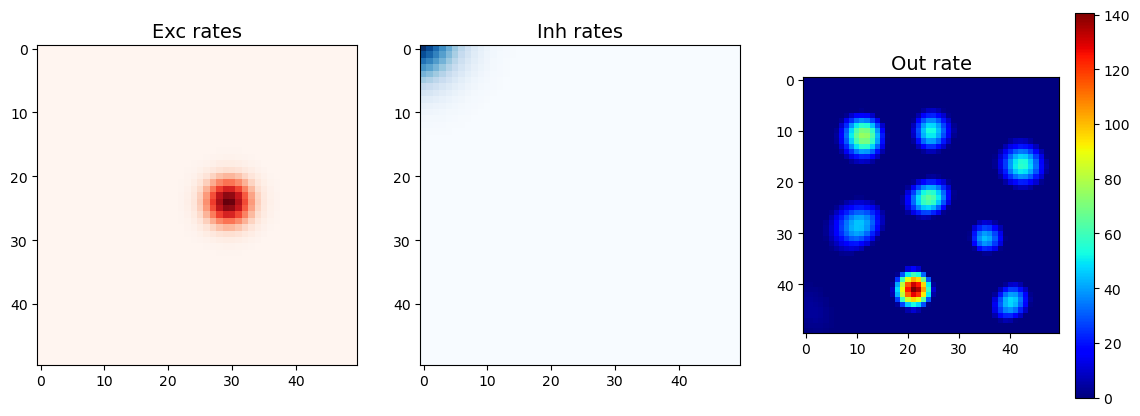

In [5]:
agent.plot_rates()
plt.savefig("nice_sargolini_grids.pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


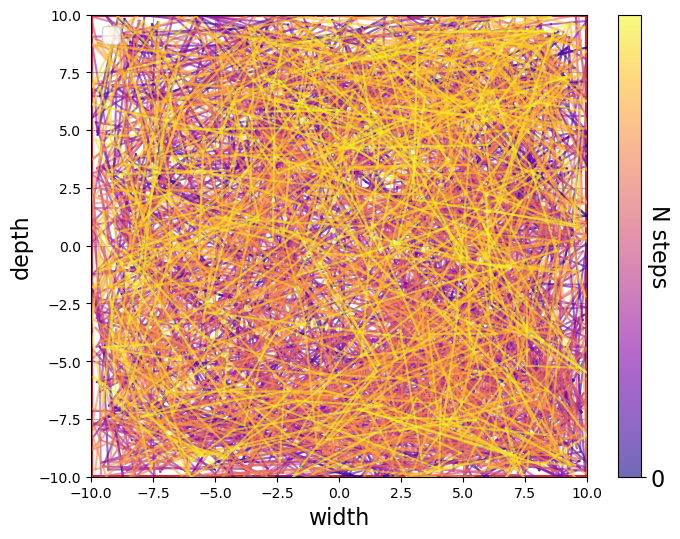

In [6]:
ax = envsimple.plot_trajectory(plot_every=100)
fontsize = 16
ax.grid()
ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
plt.show()

# Hafting-like

In [2]:
room_width = [-10,10]
room_depth = [-1.0, 1.0]
env_name = "env_example"
time_step_size = 1
agent_step_size = 0.5

# Init environment
envsimple = Simple2D(arena_x_limits = room_width,
                     arena_y_limits = room_depth,
                     time_step_size = time_step_size,
                     agent_step_size = agent_step_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4900/4900 [00:01<00:00, 4062.39it/s]


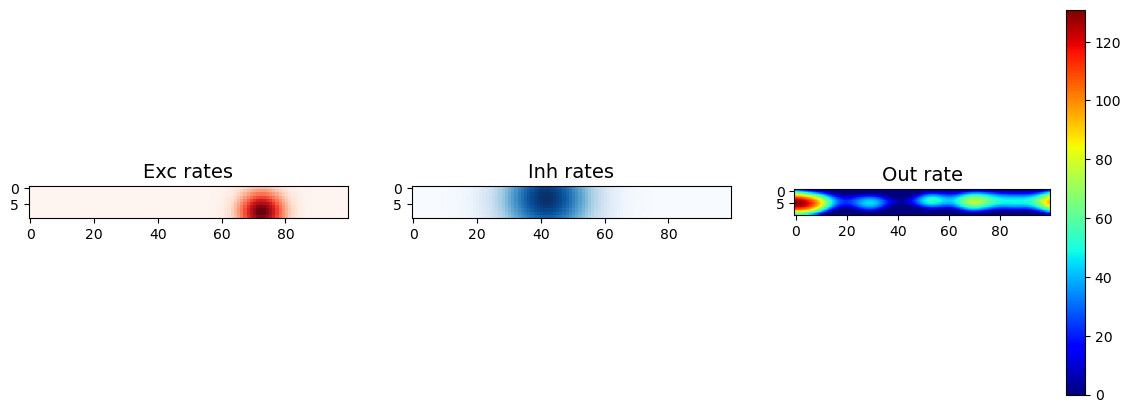

In [12]:
exc_eta = 2e-4
inh_eta = 8e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 4900
Ni = 1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.5
agent_step_size = 0.1
resolution = 100
agent = Weber2018(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                  sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=1,
                  Nef=Nef, Nif=Nif, room_width=envsimple.room_width, room_depth=envsimple.room_depth,
                  alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init, resolution=resolution)

agent.plot_rates()
plt.savefig("nice_hafting_init.pdf", bbox_inches="tight")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [20:29<00:00, 325.23it/s]


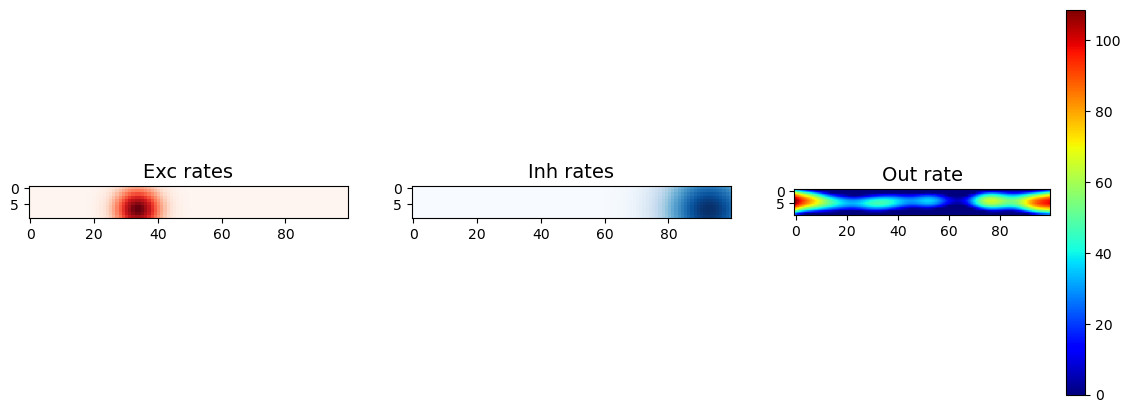

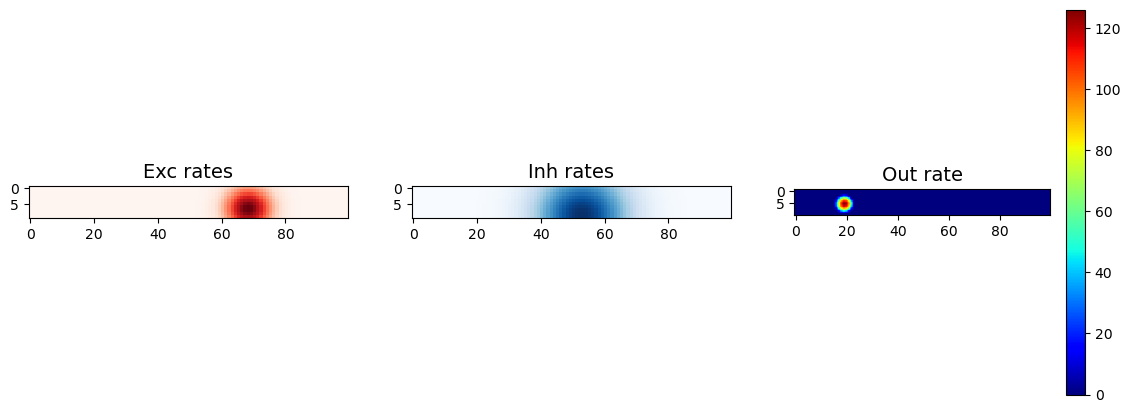

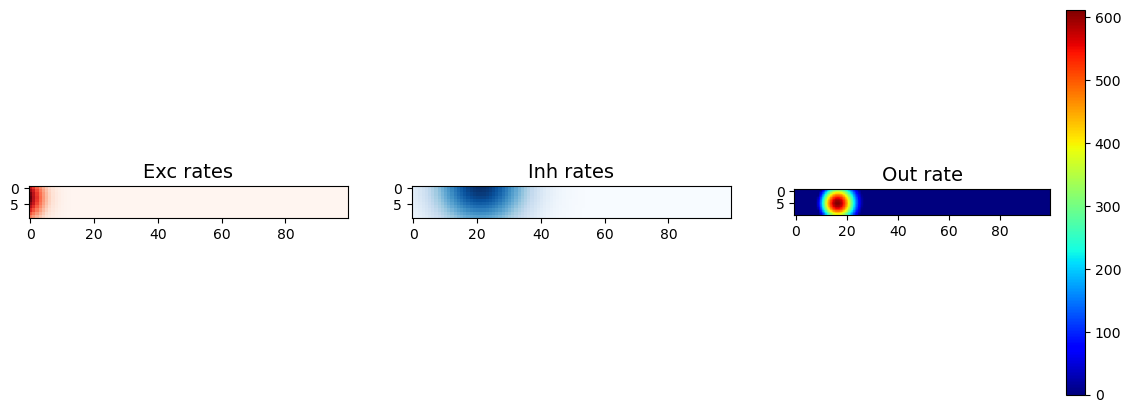

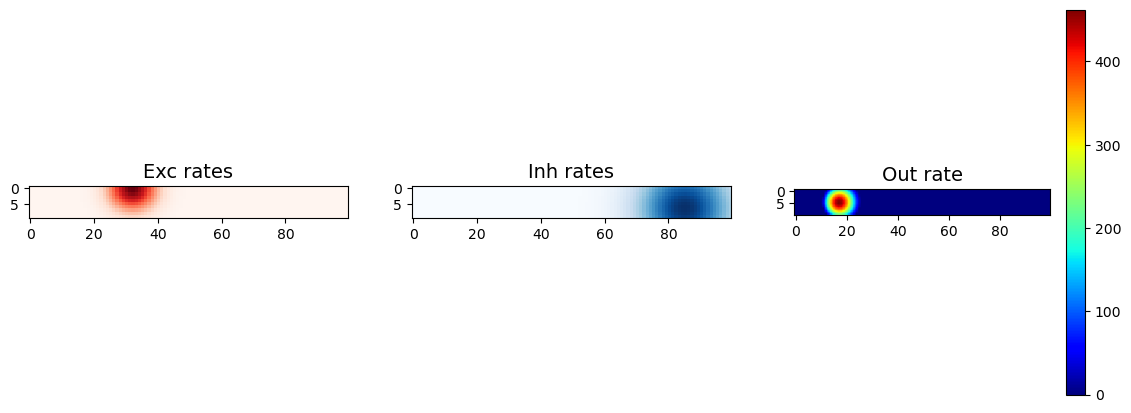

In [4]:
plot_every = 100000
total_iters = 0
n_steps = 400000
obs, state = envsimple.reset()
for i in tqdm(range(n_steps)):
    # Observe to choose an action 
    obs = obs[:2]
    action = agent.act(obs)
    # rate = agent.update()
    agent.update()
    # Run environment for given action
    obs, state, reward = envsimple.step(action, normalize_step=True)
    total_iters += 1
    if i % plot_every == 0:
        agent.plot_rates()

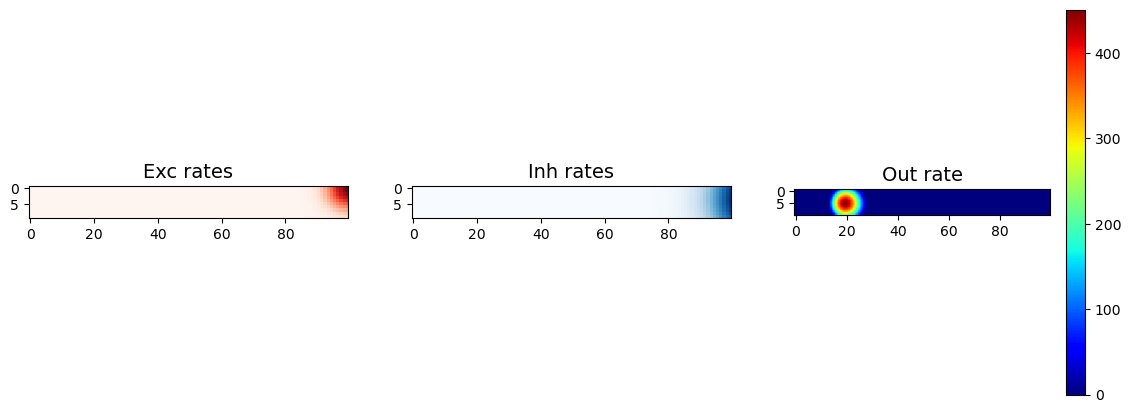

In [5]:
rate_axis = agent.plot_rates()
plt.savefig("nice_hafting_grids.pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


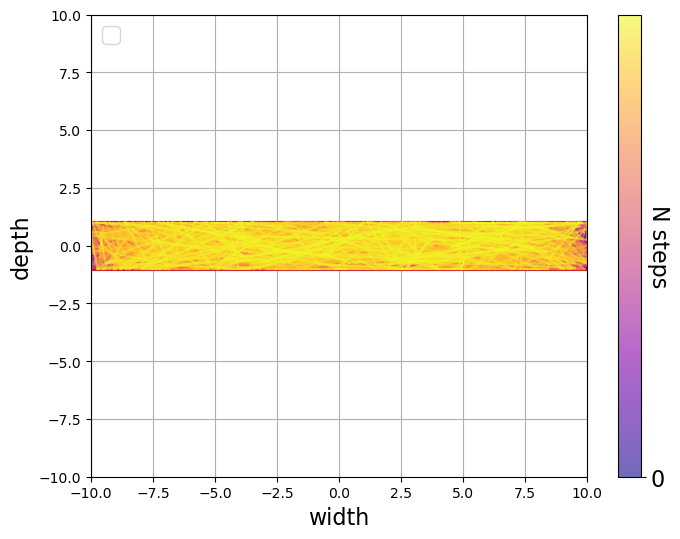

In [6]:
ax = envsimple.plot_trajectory(plot_every=100)
fontsize = 16
ax.grid()
ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
plt.show()

# Merging room experiment

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9800/9800 [00:02<00:00, 3826.80it/s]


array([<AxesSubplot: title={'center': 'Exc rates'}>,
       <AxesSubplot: title={'center': 'Inh rates'}>,
       <AxesSubplot: title={'center': 'Out rate'}>], dtype=object)

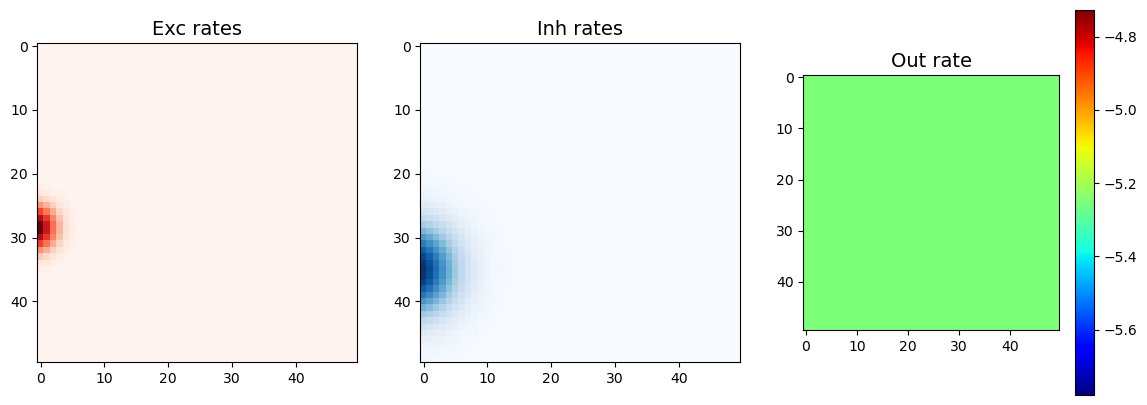

In [6]:
exc_eta = 1.3e-4
inh_eta = 5.3e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 2*4900
Ni = 2*1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.51
agent_step_size = 1.0
agent = Weber2018(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                  sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=1,
                  Nef=Nef, Nif=Nif, room_width=envsimple.room_width, room_depth=envsimple.room_depth,
                  alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)

agent.plot_rates()

In [7]:
# Random agent generates a brownian motion. Levy flight is still experimental.
# policy_agent = LevyFlightAgent(step_size=0.8, scale=2.0, loc=0.0, beta=1.0, alpha=0.5, max_action_size=100)

In [8]:
# agent.agent_step_size

In [9]:
time_step_size = 0.2
merging_time = 270*2.0  # Time in minutes to remove 
switch_time = 270.0 # Time in minutes to move the mouse to the other side of the arena
additional_time = 270.0

n_steps = ((merging_time + switch_time + additional_time)*60) / time_step_size
fontsize = 16

room_width = [-10,10]
room_depth = [-10,10]
env_name = "merging_room"

# Init environment
env = MergingRoom(arena_x_limits = room_width,
                  arena_y_limits = room_depth,
                  time_step_size = time_step_size,
                  agent_step_size = agent_step_size,
                  merge_time = merging_time,
                  switch_time = switch_time)

print(n_steps)
print(int((merging_time*60)/time_step_size))
print(int((switch_time*60)/time_step_size))

324000.0
162000
81000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324000/324000 [39:19<00:00, 137.30it/s]


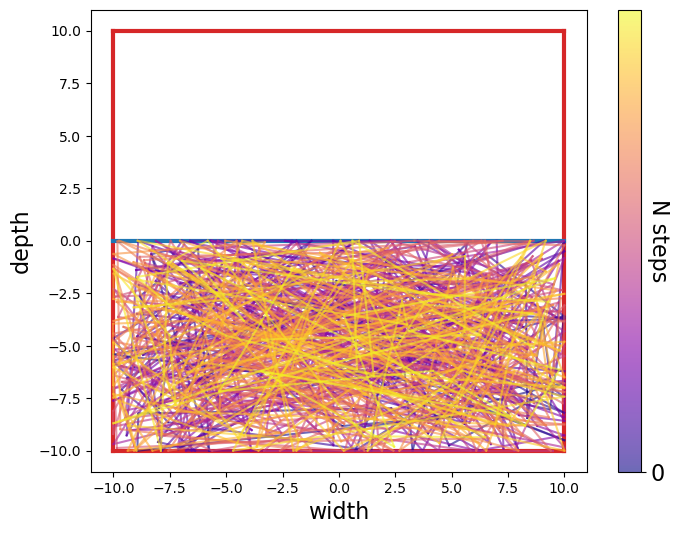

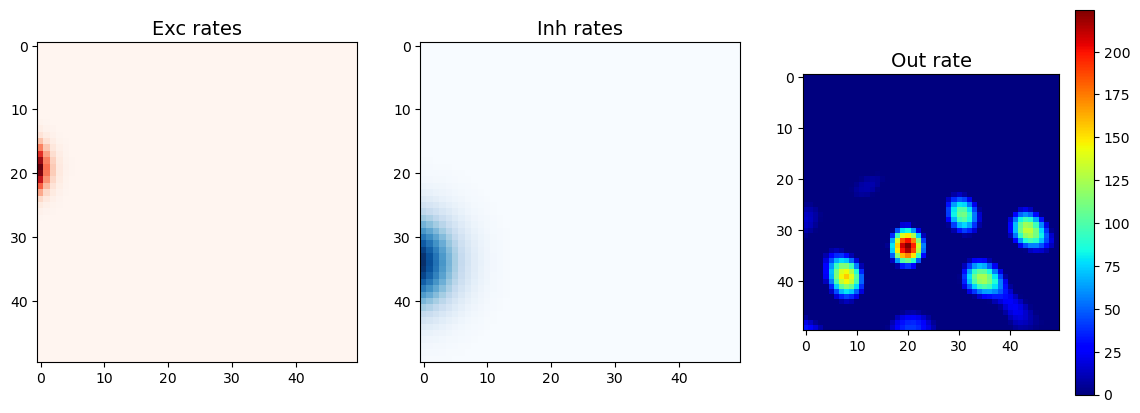

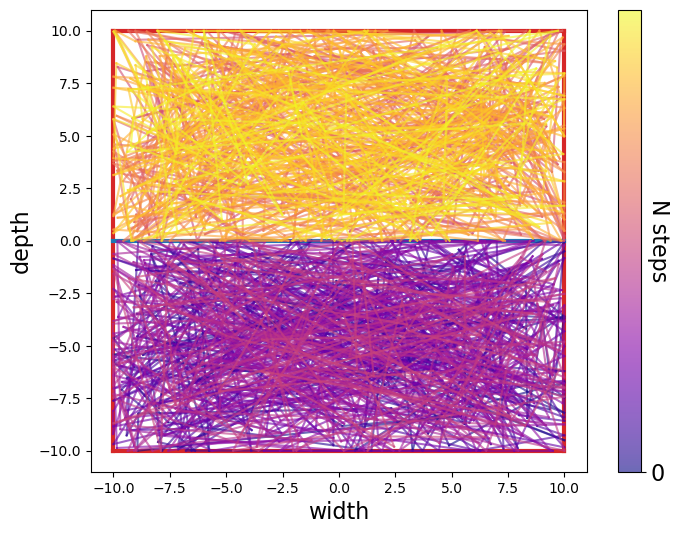

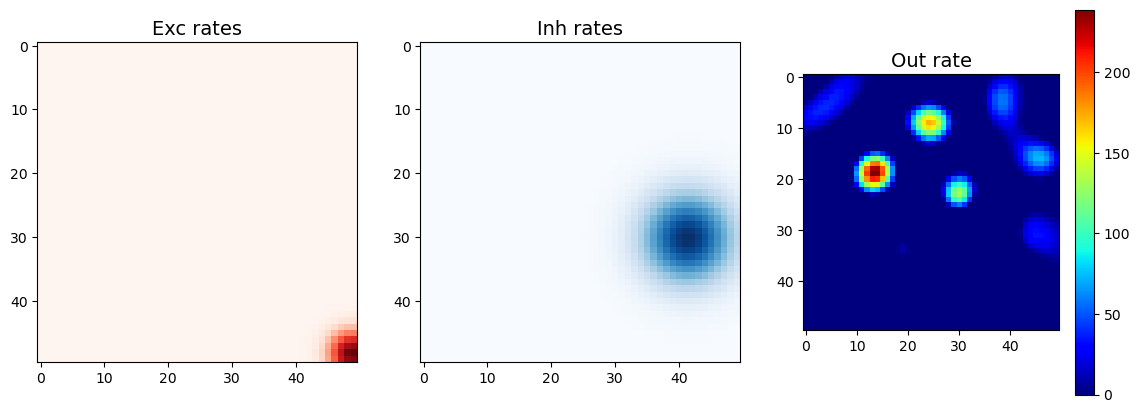

In [10]:
obs, state = env.reset()

for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    #action = agent.act(obs, policy_func=policy_agent.act)
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)
    agent.update()
    # We plot the trajectory of the agent just right before the merge
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        agent.save_agent("pre_switch.agent")
        agent.plot_rates()
        plt.savefig("pre_switch.pdf", bbox_inches="tight")
    if j == int((merging_time*60)/time_step_size)-1:
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        agent.plot_rates()
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        agent.save_agent("pre_merge.agent")
agent.save_agent("post_merge.agent")

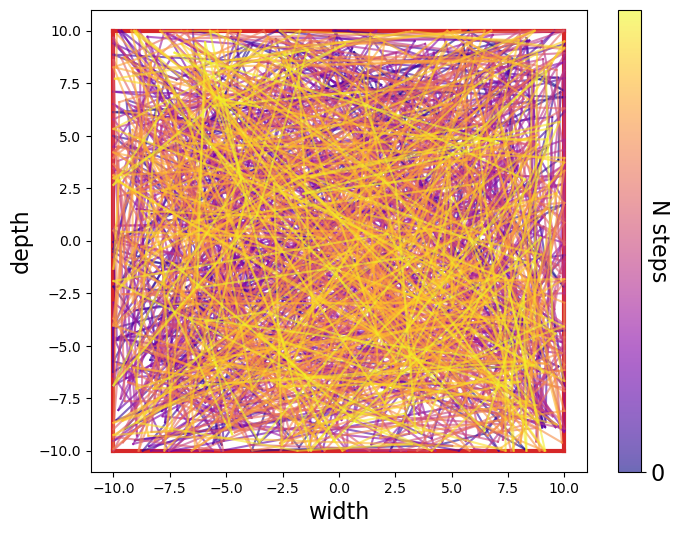

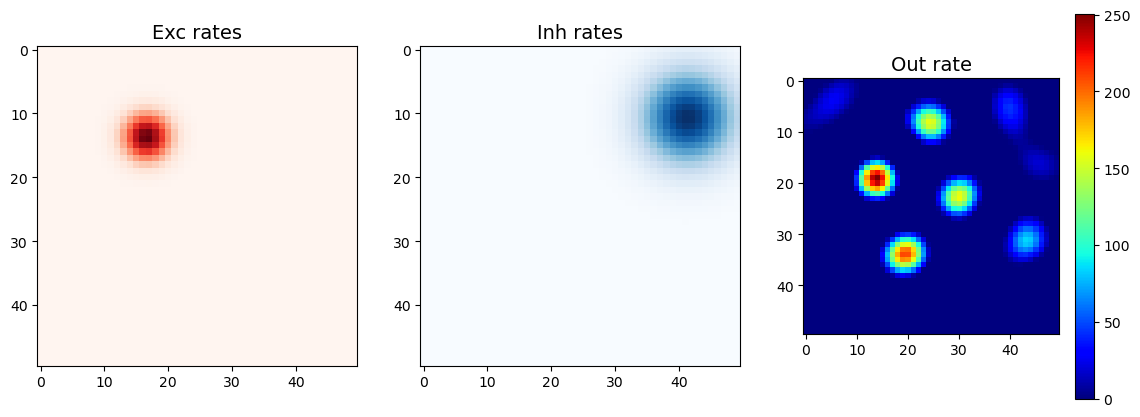

In [11]:
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)

agent.plot_rates()
plt.savefig("post_merge.pdf", bbox_inches="tight")

In [12]:
env.switch_time

81000

In [13]:
env.global_steps

324000

In [14]:
env.merge_time

162000